# BezierPalm3d

This notebook demonstrates 3D hand rendering in Bezier3D model.

In particular, the notebook demonstrates how to sample **hand shape and guesture parameters** and render hand images using PyTorch3D and MANO.

A color gradient texture image is used for better illustration. You can chain the Bezier2d and Bezier3d by using the 2D synthesized palmer images as texture in 3D rendering.

A full pipeline for pretraining image synthesis would be:
1. Synthesize 2d palmar images using 'synthesize2d.py'
2. Use the synthesized 2d images as texture in 3D rendering.

Check <https://kaizhao.net/palmprint> for more information.

In [1]:
from mmcv import image
import torch
import mano
import random

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import vlkit.plt as vlplt

from PIL import Image

import os, sys, argparse, random, glob
import os.path as osp
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import mmcv

import pytorch3d
from pytorch3d.io import load_objs_as_meshes, load_obj, IO
from pytorch3d.ops import sample_points_from_meshes, SubdivideMeshes
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.transforms import axis_angle_to_matrix
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    TexturesUV,
    TexturesVertex
)

from palm3d import get_mano, get_vjf, render

In [2]:
bsize = 5
image_size = [1000, 1000]
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

In [3]:
mano_model = get_mano(batch_size=10, is_right=True).to(device)

uv_data = torch.load('assets/uv_data.pth')


concave = torch.from_numpy(np.load('assets/hand_mean.npy')).to(device)
flat = torch.zeros_like(concave)

global_orient = torch.zeros(bsize, 3).to(device)
translate = torch.zeros(bsize, 3).to(device)

In [4]:
beta = (torch.randn(1, 10)*.1).repeat(bsize, 1).to(device)

alpha = torch.linspace(0, 1.5, bsize).view(bsize, 1).to(beta)
pose = alpha * concave + (1 - alpha) * flat

In [5]:
verts, joints, faces = get_vjf(mano_model, beta, pose, global_orient, translate)
meshes = pytorch3d.structures.Meshes(verts.to(device), faces.to(device))

In [6]:
tex_fn = 'color-grad.jpg'
tex_img = np.array(Image.open(tex_fn).resize(image_size))

textures = torch.from_numpy(tex_img[None,] / 255).to(beta).repeat(bsize, 1, 1, 1)

meshes.textures = TexturesUV(
    verts_uvs=[uv_data['verts_uvs'].to(device),] * bsize,
    faces_uvs=[uv_data['faces_uvs'].to(device),] * bsize,
    maps = textures)

In [7]:
R, T = look_at_view_transform(
    dist=np.random.uniform(2.0, 2.8),
    elev=np.random.uniform(270-10, 270+10),
    azim=np.random.uniform(-10, +10),
    up = ((-1, 0, 0),))
images, cameras = render(meshes, R.to(device), T.to(device), image_size=image_size)
images = images[:, :, :, 0:3].cpu().numpy()

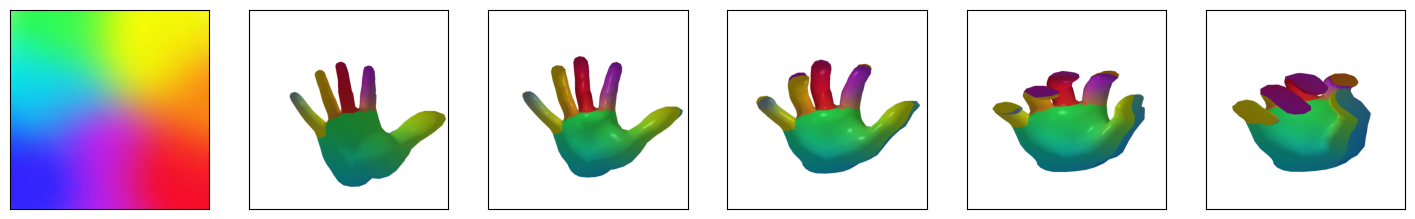

In [8]:
fig, axes = plt.subplots(1, bsize+1, figsize=((bsize+1)*3, 3))
vlplt.clear_ticks(axes)
axes[0].imshow(tex_img)
for i in range(1, bsize+1):
    axes[i].imshow(images[i-1])

torch.save({'tex_img': torch.tensor(tex_img), 'images': torch.tensor(images)}, f'{tex_fn}.pth')

In [9]:
# Image.fromarray(torch.tensor(np.array(Image.open('color-grad.jpg'))).flip(dims=(0,)).numpy()).save('color-grad.jpg')

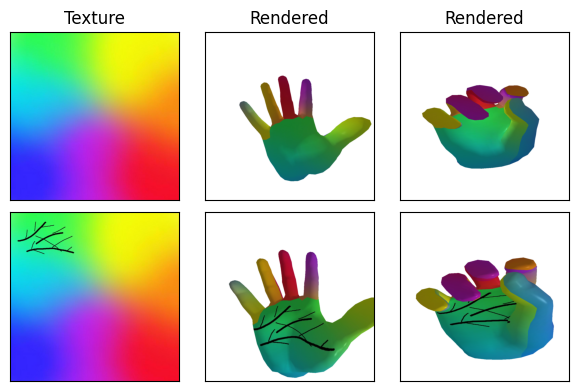

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(6,4))
vlplt.clear_ticks(axes)

color_grad = torch.load('color-grad.jpg.pth')
sketch = torch.load('color-grad1.jpg.pth')

axes[0, 0].set_title('Texture')
axes[0, 0].imshow(color_grad['tex_img'])
axes[0, 1].set_title('Rendered')
axes[0, 1].imshow(color_grad['images'][0])
axes[0, 2].set_title('Rendered')
axes[0, 2].imshow(color_grad['images'][-1])

axes[1, 0].imshow(sketch['tex_img'])
axes[1, 1].imshow(sketch['images'][0])
axes[1, 2].imshow(sketch['images'][-1])
plt.tight_layout()
plt.savefig('tex-rendered.pdf')

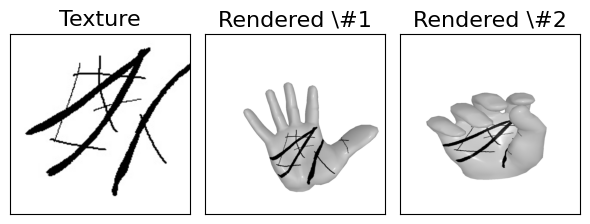

In [11]:
tex_fn = 'creases.jpg'
tex_img = np.array(Image.open(tex_fn).resize(image_size))

textures = torch.from_numpy(tex_img[None,] / 255).to(beta).repeat(bsize, 1, 1, 1)

meshes.textures = TexturesUV(
    verts_uvs=[uv_data['verts_uvs'].to(device),] * bsize,
    faces_uvs=[uv_data['faces_uvs'].to(device),] * bsize,
    maps = textures)

R, T = look_at_view_transform(
    dist=np.random.uniform(2.0, 2.8),
    elev=np.random.uniform(270-10, 270+10),
    azim=np.random.uniform(-10, +10),
    up = ((-1, 0, 0),))
images, cameras = render(meshes, R.to(device), T.to(device), image_size=image_size)
images = images[:, :, :, 0:3].cpu().numpy()

R, T = look_at_view_transform(
    dist=np.random.uniform(2.0, 2.8),
    elev=np.random.uniform(270-10, 270+10),
    azim=np.random.uniform(-10, +10),
    up = ((-1, 0, 0),))
images, cameras = render(meshes, R.to(device), T.to(device), image_size=image_size, light=[0, -5, 0])
images = images[:, :, :, 0:3].cpu().numpy()


fig, axes = plt.subplots(1, 3, figsize=(6,4))
vlplt.clear_ticks(axes)

axes[0].set_title('Texture', fontsize=16)
axes[1].set_title('Rendered \#1', fontsize=16)
axes[2].set_title('Rendered \#2', fontsize=16)

axes[0].imshow(tex_img[0:400, 0:400])
axes[1].imshow(images[0])
axes[2].imshow(images[-1])
plt.tight_layout()